In [507]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os.path as osp
import os
from glob import glob
from sklearn.metrics import average_precision_score
from scipy.special import softmax, expit

import datetime

In [548]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_base'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_resample'

# experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_resample_InstanceHardnessThreshold'

experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\experiments'
run_name = r'retrained_base_model_CondensedNearestNeighbour'
# run_name = r'retrained_base_model_CondensedNearestNeighbour_crossent_loss'
path_to_log = glob(osp.join(experiment_folder,run_name,'output_train_data','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval_sigmoid','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval_softmax','*.txt'))
# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))



# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual'

In [549]:
from torch.nn.functional import one_hot
def inverse_sigmoid(y):
    return np.log(y / (1 - y))

def one_esque(arr):
    ret = np.zeros_like(arr)
    ret[np.argmax(arr)] = 1
    return ret
# # 
# k = [0.056121826171875, 0.047607421875, 0.058990478515625, 0.04986572265625, 0.07122802734375, 0.051849365234375, 0.05450439453125, 0.06292724609375, 0.059661865234375, 0.05572509765625, 0.052337646484375, 0.05194091796875, 0.045684814453125, 0.053192138671875, 0.046905517578125, 0.049591064453125, 0.054595947265625]
# 
# a = np.array(k)
# b = inverse_sigmoid(a)
# c = softmax(b)
# d = expit(a)
# 
# print(f'{a=}')
# # print(f'{b=}')
# # print(f'{c=}')
# print(f'{d=}')
# print(f'{one_esque(a)=}')


In [550]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, is_multi_label=False):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, is_multi_label=is_multi_label)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        if is_multi_label:
            # match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
            match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
            if match:
        
    
                # index = int(match.group(1))
                index = match.group(1)
                
                # Extract model predictions and convert to list using ast
                logits_str = match.group(2)
                logits = list(ast.literal_eval(logits_str))
                # logits = expit(np.array(logits)).tolist()
                # logits = softmax(logits)
                
                
                
                # predictions = ((np.array(logits)>0.5).astype(int)).tolist()
                predictions = (one_esque(np.array(logits)).astype(int)).tolist()
            
    
                # Extract targets and convert to list using ast
                targets_str = f'[{match.group(3)}]'
                targets = list(np.array(ast.literal_eval(targets_str)))
    
                
                row_data = logits + predictions + targets 
                row_data = np.array(row_data)
                data.append(row_data)
                # indecies.append(int(index))
                indecies.append(index)
                # Create column names
            logit_columns = [f"logit-{name}" for name in feature_names]
            pred_columns = [f"pred-{name}" for name in feature_names]    
            gt_columns = [f"gt-{name}" for name in feature_names]       
            columns = logit_columns + pred_columns + gt_columns 
        else:
            match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)\s+(\d+)', line.strip())
            if match:
        
    
                # index = int(match.group(1))
                index = match.group(1)
                
                # Extract model predictions and convert to list using ast
                logits_str = match.group(2)
                logits = list(ast.literal_eval(logits_str))
                
                predictions = [np.argmax(logits)]
    
    
                # Extract targets and convert to list using ast
                targets = [match.group(3)]
    
                
                row_data = logits + predictions + targets 
                row_data = np.array(row_data)
                data.append(row_data)
                # indecies.append(int(index))
                indecies.append(index)
            


            # Create column names
            logit_columns = [f"logit-{name}" for name in feature_names]
            pred_columns = ['pred']    
            gt_columns = ['gt']       
            columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)


    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    # df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns


df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names, is_multi_label=True)

In [551]:
# df[pred_columns[0]]

In [552]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset/weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [553]:
def pars_metadata(metadata):
    metadata_dict_list = []
    for line in metadata:
        metadata_dict_list.append(ast.literal_eval(line))
    df = pd.DataFrame(metadata_dict_list)
    return df, metadata_dict_list

In [554]:

# path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')
# Get names of file names from the csv file

df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df_metadata, metadata_dict_list = pars_metadata(metadata)

In [555]:


df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names, is_multi_label=True)
# data, columns = load_and_parse_txt(path_to_log, feature_names)
# df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

In [556]:
# validate labels
labels = df[gt_columns]
labels = labels.sum()
labels


gt-0     16
gt-1     19
gt-2     45
gt-3      9
gt-4     73
gt-5     14
gt-6     25
gt-7     54
gt-8     81
gt-9      9
gt-10    12
gt-11    40
gt-12    17
gt-13    22
gt-14     6
gt-15     9
gt-16    16
dtype: int64

In [557]:
def add_metadata(df_e, df_metadata):
    # df_e['rec_no'] = df_metadata['rec_no'].values
    # df_e['subject_pos'] = df_metadata['subject_pos'].values
    df_e['view'] = df_metadata['view'].values
    df_e['sample_id'] = df_metadata['sample_id'].values
    return df_e

In [558]:
df_g = df.groupby('log_name')
df_with_meta_list = []
for logname , df_e in df_g:
    df_with_meta_list.append(add_metadata(df_e, df_metadata))

df_with_meta = pd.concat(df_with_meta_list)


In [559]:
df_with_meta

,logit-0,logit-1,logit-2,logit-3,logit-4,logit-5,logit-6,logit-7,logit-8,logit-9,...,gt-10,gt-11,gt-12,gt-13,gt-14,gt-15,gt-16,log_name,view,sample_id
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0008_color_0054,0.060760,0.060089,0.062683,0.055298,0.048676,0.057190,0.060638,0.063049,0.066467,0.057190,...,0,0,0,0,0,0,0,0.txt,center,0008_0054
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0009,0.068909,0.071350,0.068542,0.062927,0.045685,0.065613,0.072632,0.067932,0.076538,0.064392,...,0,0,0,0,0,0,0,0.txt,center,0002_0009
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0015,0.065125,0.066223,0.065491,0.059113,0.046478,0.061432,0.067078,0.065125,0.071594,0.060760,...,0,0,0,0,0,0,0,0.txt,center,0002_0015
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0017,0.064087,0.065002,0.064514,0.058228,0.047089,0.060425,0.065491,0.064392,0.070312,0.059753,...,0,0,0,0,0,0,0,0.txt,center,0002_0017
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0021,0.067932,0.071228,0.066956,0.062805,0.046295,0.065002,0.071594,0.066223,0.075745,0.063232,...,0,0,0,0,0,0,0,0.txt,center,0002_0021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0005_color_0109,0.061646,0.064087,0.060974,0.060303,0.052704,0.061188,0.064087,0.061432,0.070435,0.059967,...,0,0,0,0,0,0,1,0.txt,center,0005_0109
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0015_color_0103,0.086914,0.099487,0.081543,0.087708,0.051453,0.090576,0.102295,0.078918,0.103943,0.084961,...,0,0,0,0,0,0,1,0.txt,center,0015_0103
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0016_color_0053,0.047516,0.043610,0.053406,0.049774,0.078918,0.048859,0.044098,0.056641,0.053589,0.051453,...,0,0,0,0,0,0,1,0.txt,center,0016_0053
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0016_color_0072,0.060211,0.063843,0.060089,0.062805,0.057190,0.062927,0.064209,0.060516,0.071228,0.061523,...,0,0,0,0,0,0,1,0.txt,center,0016_0072


In [560]:
# df = df_with_meta.drop(columns='log_name').groupby(['sample_id','rec_no','subject_pos','view']).mean().reset_index()
# df = df_with_meta.drop(columns='log_name').groupby(['sample_id']).mean().reset_index()
df.head()

,logit-0,logit-1,logit-2,logit-3,logit-4,logit-5,logit-6,logit-7,logit-8,logit-9,...,gt-8,gt-9,gt-10,gt-11,gt-12,gt-13,gt-14,gt-15,gt-16,log_name
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0008_color_0054,0.060760,0.060089,0.062683,0.055298,0.048676,0.057190,0.060638,0.063049,0.066467,0.057190,...,0,0,0,0,0,0,0,0,0,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0009,0.068909,0.071350,0.068542,0.062927,0.045685,0.065613,0.072632,0.067932,0.076538,0.064392,...,0,0,0,0,0,0,0,0,0,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0015,0.065125,0.066223,0.065491,0.059113,0.046478,0.061432,0.067078,0.065125,0.071594,0.060760,...,0,0,0,0,0,0,0,0,0,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0017,0.064087,0.065002,0.064514,0.058228,0.047089,0.060425,0.065491,0.064392,0.070312,0.059753,...,0,0,0,0,0,0,0,0,0,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\train\Sample0002_color_0021,0.067932,0.071228,0.066956,0.062805,0.046295,0.065002,0.071594,0.066223,0.075745,0.063232,...,0,0,0,0,0,0,0,0,0,0.txt


In [561]:
# Summarize metrics using classification report
def generate_report(df):
    gt = df[gt_columns].astype(int)
    predictions = df[pred_columns].astype(int)
    logits = df[logit_columns]

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    return df_report, logits, gt
df_report, logits, gt = generate_report(df)
df = df.reset_index()
df_report


C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,16.0
1,0.000000,0.000000,0.000000,19.0
2,0.000000,0.000000,0.000000,45.0
3,0.000000,0.000000,0.000000,9.0
4,0.330317,1.000000,0.496599,73.0
5,0.000000,0.000000,0.000000,14.0
6,0.000000,0.000000,0.000000,25.0
7,0.272727,0.055556,0.092308,54.0
8,0.209302,0.444444,0.284585,81.0
9,0.000000,0.000000,0.000000,9.0


In [562]:
# Calculate ROC-AUC for each label
roc_auc_scores = {}
roc_metrics = {}

for column in feature_names:
    if not isinstance(column, str):
        column = str(column)
    true_label = gt['gt-'+column]
    pred_prob = logits['logit-'+column]
    support = sum(true_label)
    try:
        roc_auc = roc_auc_score(true_label, pred_prob)
    except:
        roc_auc = np.nan
    roc_auc_scores[column] = roc_auc
    try:
        fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
    except: 
        fpr, tpr, thresholds = np.nan, np.nan, np.nan
        
    roc_metrics[column] = dict(
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc = roc_auc,
        support = support
    )


# Display ROC-AUC scores for each label
for label, roc_auc in roc_auc_scores.items():
    print(f'ROC-AUC for {label}: {roc_auc}')

ROC-AUC for 0: 0.5744179600886918
ROC-AUC for 1: 0.7748472744360901
ROC-AUC for 2: 0.39928909952606634
ROC-AUC for 3: 0.5752062105773896
ROC-AUC for 4: 0.9494993394061609
ROC-AUC for 5: 0.6337906023336486
ROC-AUC for 6: 0.8414932126696832
ROC-AUC for 7: 0.4109721101246525
ROC-AUC for 8: 0.45651826264952344
ROC-AUC for 9: 0.4104803493449781
ROC-AUC for 10: 0.6695054945054946
ROC-AUC for 11: 0.6116217798594847
ROC-AUC for 12: 0.860326797385621
ROC-AUC for 13: 0.505311542390194
ROC-AUC for 14: 0.8915401301518437
ROC-AUC for 15: 0.6550218340611353
ROC-AUC for 16: 0.7137610864745011


In [563]:
roc_auc_scores

{'0': 0.5744179600886918,
 '1': 0.7748472744360901,
 '2': 0.39928909952606634,
 '3': 0.5752062105773896,
 '4': 0.9494993394061609,
 '5': 0.6337906023336486,
 '6': 0.8414932126696832,
 '7': 0.4109721101246525,
 '8': 0.45651826264952344,
 '9': 0.4104803493449781,
 '10': 0.6695054945054946,
 '11': 0.6116217798594847,
 '12': 0.860326797385621,
 '13': 0.505311542390194,
 '14': 0.8915401301518437,
 '15': 0.6550218340611353,
 '16': 0.7137610864745011}

In [564]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
# optimal_th_dict


In [565]:
optimal_preds = {}
for column in feature_names:
    column_str = str(column)
        
    pred_prob = logits['logit-'+column_str]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds[column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [566]:
classification_rep = classification_report(gt, df_optimal_preds, output_dict=True, target_names=feature_names)
df_report_optimal = pd.DataFrame.from_dict(classification_rep).transpose()
# index_mapping = {str(idx): feature_name for idx, feature_name in enumerate(FEATURE_NAMES)}
# df_report.rename(index=index_mapping, inplace=True)
df_report_optimal.sort_values(by='support')

C:\Users\user\anaconda3\envs\micro\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
14,0.054945,0.833333,0.103093,6.0
15,0.035176,0.777778,0.067308,9.0
3,0.046512,0.222222,0.076923,9.0
9,0.023810,0.111111,0.039216,9.0
10,0.049383,0.666667,0.091954,12.0
5,0.190476,0.285714,0.228571,14.0
16,0.068966,0.750000,0.126316,16.0
0,0.049550,0.687500,0.092437,16.0
12,0.080000,0.941176,0.147465,17.0
1,0.080402,0.842105,0.146789,19.0


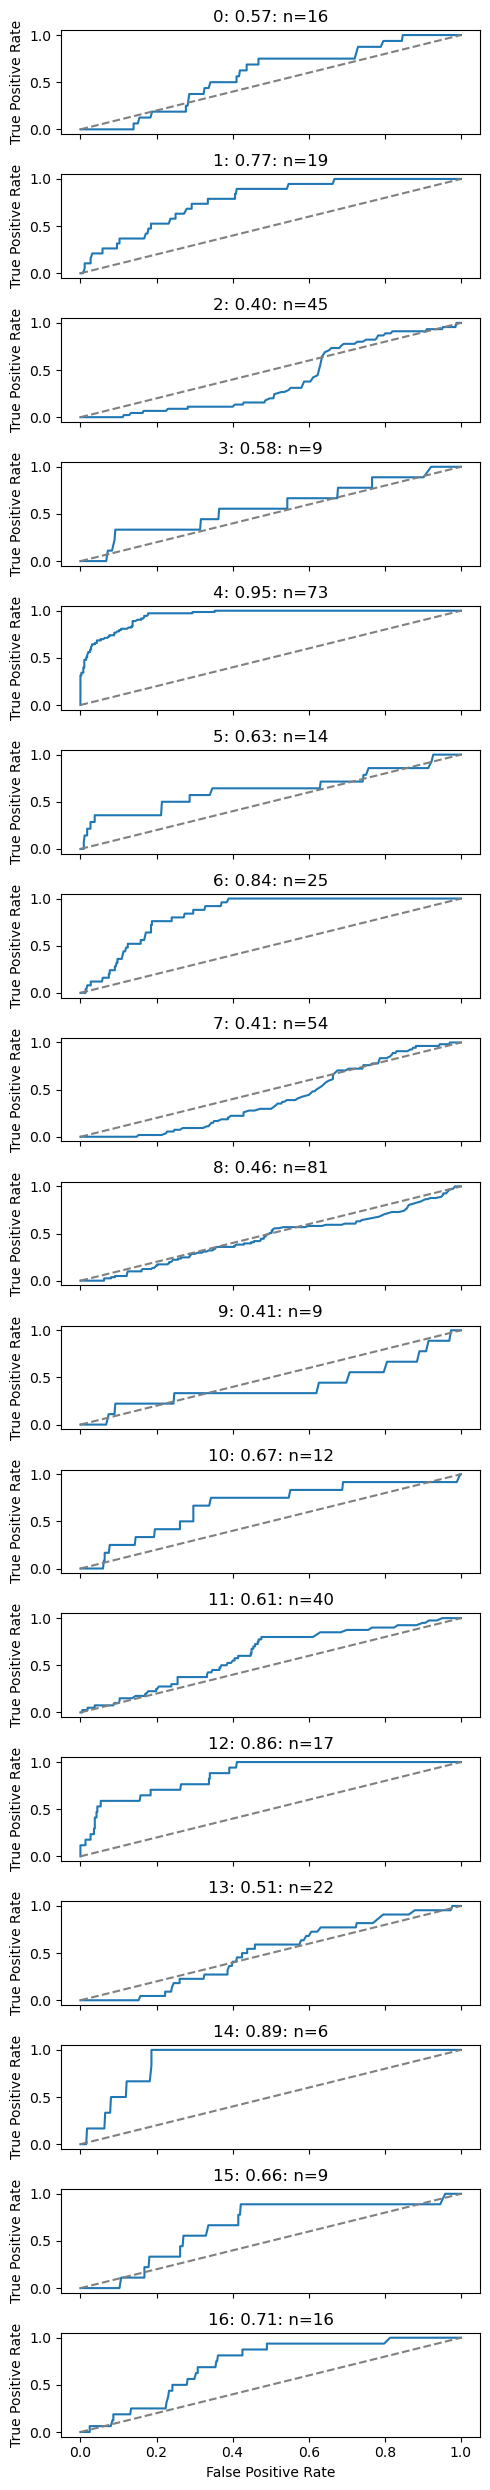

In [567]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 25))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']
    sup = metrics['support']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    axes[i].set_title(f'{label}: {auc_value:.2f}: n={sup}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [287]:
# print("Mean Average Precision:", map_score)

In [289]:
# df.reset_index()[['sample_id', 'rec_no', 'subject_pos', 'view']].head()

In [290]:
df.columns

Index(['index', 'logit-0', 'logit-1', 'logit-2', 'logit-3', 'logit-4',
       'logit-5', 'logit-6', 'logit-7', 'logit-8', 'logit-9', 'logit-10',
       'logit-11', 'logit-12', 'logit-13', 'logit-14', 'logit-15', 'logit-16',
       'pred-0', 'pred-1', 'pred-2', 'pred-3', 'pred-4', 'pred-5', 'pred-6',
       'pred-7', 'pred-8', 'pred-9', 'pred-10', 'pred-11', 'pred-12',
       'pred-13', 'pred-14', 'pred-15', 'pred-16', 'gt-0', 'gt-1', 'gt-2',
       'gt-3', 'gt-4', 'gt-5', 'gt-6', 'gt-7', 'gt-8', 'gt-9', 'gt-10',
       'gt-11', 'gt-12', 'gt-13', 'gt-14', 'gt-15', 'gt-16', 'log_name'],
      dtype='object')

In [292]:
# df_view_agg = df.drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

In [293]:
# df_view_agg = df.drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

In [294]:
# df_view_agg = df.loc[df['view']=='front1'].drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

In [295]:
# df_view_agg = df.loc[df['view']=='front2'].drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

In [296]:
# df_view_agg = df.loc[df['view']=='left'].drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))b

In [297]:
# df_view_agg = df.loc[df['view']=='right'].drop(columns='view').groupby('sample_id').mean()
# y_true = df_view_agg[gt_columns].astype(int).values
# y_pred = df_view_agg[logit_columns].values
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
# print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

In [42]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels for a multilabel classification task
# Each sample can have multiple labels

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred>0.5)

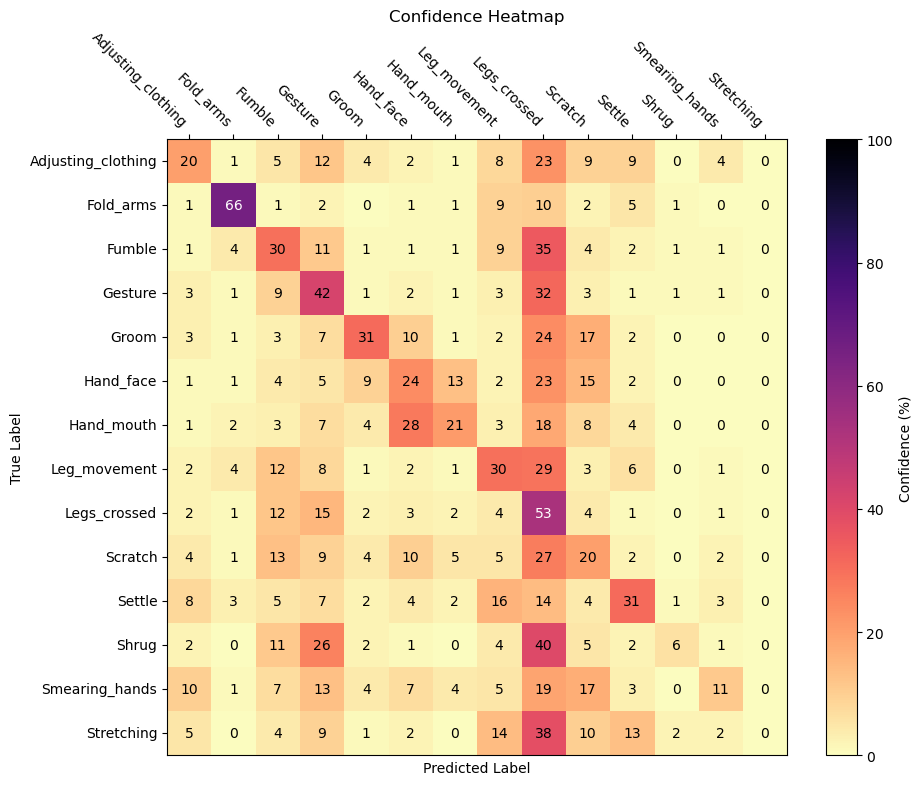

In [43]:
import matplotlib.pyplot as plt


def plot_confidence_heatmap(y_true, y_pred, feature_names):
    n_features = len(feature_names)
    n_samples = y_true.shape[0]

    # Initialize a matrix to store confidence values for each label
    confidence_matrix = np.zeros((n_features, n_features))

    # Iterate through each label
    for label_idx in range(n_features):
        # Get indices where ground truth is 1 for the current label
        label_indices = np.where(y_true[:, label_idx] == 1)[0]

        # If no samples have this label, skip
        if len(label_indices) == 0:
            continue

        # Get mean y_pred vector for rows where ground truth is 1 for this label
        mean_y_pred = np.mean(y_pred[label_indices], axis=0)  
        mean_y_pred /= np.sum(mean_y_pred)
        mean_y_pred *= 100  # Convert to percentage confidence value
        mean_y_pred = np.round(mean_y_pred).astype(int)  # Round 

        # Store the confidence values for the current label
        confidence_matrix[label_idx] = mean_y_pred # Convert to int

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(confidence_matrix, cmap='magma_r', aspect='auto', vmin=0, vmax=100)  # Set colormap scale
    plt.colorbar(label='Confidence (%)')
    for i in range(n_features):
        for j in range(n_features):
            c = 'white' if confidence_matrix[i, j] > 50 else 'black'  # Set text color based on confidence value
            plt.text(j, i, str(int(confidence_matrix[i, j])), ha='center', va='center', color=c)
    plt.xticks(np.arange(n_features), feature_names, rotation=-45, ha='right')
    plt.yticks(np.arange(n_features), feature_names, rotation=0, va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confidence Heatmap')
    plt.grid(False)  # Remove grid
    plt.tick_params(axis='both', direction='out')  # Ticks pointing outside
    plt.tick_params(axis='y', right=False, left=True)  # Move y-axis ticks to the left
    plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top

    # plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust subplot to fit labels
    plt.show()

plot_confidence_heatmap(y_true, y_pred, feature_names)